### Importation + installations

In [ ]:
### import json file from kaggle

from google.colab import files
files.upload()  # This will prompt you to upload the kaggle.json file

: 

In [ ]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)
os.rename('kaggle.json', '/root/.kaggle/kaggle.json')
!kaggle competitions download -c geo-ai-hack

import zipfile

with zipfile.ZipFile('geo-ai-hack.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

zip_file_path = '/content/geo-ai-hack.zip'

# Delete the zip file
os.remove(zip_file_path)

print(f"{zip_file_path} has been deleted.")

100% 39.1G/39.1G [08:01<00:00, 175MB/s]
100% 39.1G/39.1G [08:01<00:00, 87.2MB/s]


KeyboardInterrupt: 

In [ ]:
zip_file_path = '/content/geo-ai-hack.zip'

# Delete the zip file to free space
os.remove(zip_file_path)

print(f"{zip_file_path} has been deleted.")

/content/geo-ai-hack.zip has been deleted.


In [ ]:
# prompt: delete folder content/s2_train

import shutil
import os

# Define the path to the folder you want to delete
folder_path = '/content/s2_test'

# Check if the folder exists before attempting to delete it
if os.path.exists(folder_path):
  # Use shutil.rmtree to delete the folder and its contents
  shutil.rmtree(folder_path)
  print(f"Folder '{folder_path}' and its contents have been deleted.")
else:
  print(f"Folder '{folder_path}' does not exist.")


Folder '/content/s2_test' and its contents have been deleted.


In [ ]:
# Clone the InstaGeo-E2E-Geospatial-ML repository from GitHub
repository_url = "https://github.com/instadeepai/InstaGeo-E2E-Geospatial-ML"
!git clone {repository_url}

Cloning into 'InstaGeo-E2E-Geospatial-ML'...
remote: Enumerating objects: 374, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 374 (delta 80), reused 61 (delta 61), pack-reused 269 (from 1)
Receiving objects: 100% (374/374), 1.42 MiB | 21.41 MiB/s, done.
Resolving deltas: 100% (207/207), done.


In [ ]:
%%bash
cd InstaGeo-E2E-Geospatial-ML
git pull

Already up to date.


In [ ]:
%%capture
%%bash
# Navigate to the cloned InstaGeo-E2E-Geospatial-ML directory
cd /content/InstaGeo-E2E-Geospatial-ML
# Stash any local changes to avoid conflicts when switching branches
git stash
#Switch to the 'geo-ai-hack' branch, which likely contains specific code for the Geo AI Hackathon
git checkout geo-ai-hack
# Install the InstaGeo package
pip install -e .[all]

In [ ]:
# Import necessary libraries
import os
import re
import shutil
import yaml
import pandas as pd
import numpy as np
from pathlib import Path
from pyproj import CRS, Transformer
import rasterio
os.environ["HYDRA_FULL_ERROR"] ="1"

In [ ]:
# Setup code for the notebook

# Execute code 'cells' like this by clicking on the 'Run'
# button or by pressing [shift] + [Enter].

# This cell only imports some python packages that will be
# used below. It doesn't generate any output.

# The following lines install the necessary packages in the colab environment
try:
    from google.colab import files

    # download TP data and tools
    !wget -q http://boucantrin.ovh.hw.ipol.im/static/facciolo/mvaisat/tp1.2.zip
    !unzip -q -o tp1.2.zip

    # install dependencies
    !apt-get -qq -o=Dpkg::Use-Pty=0 update && apt install -qq -o=Dpkg::Use-Pty=0 gdal-bin
    !python -m pip -q install rpcm rasterio
    !python -m pip -q install numpy utm python-dateutil tifffile shapely geojson enum34 features filelock matplotlib scipy pyproj scikit-image numba pillow opencv-contrib-python~=4.8.0.76  pandas setuptools srtm4 folium
    # install latest TSD
    !python -m pip -q install tsd==0.9.0
    #!pip install pypotree



except ImportError:
    %matplotlib notebook
    pass


## Setup code for the notebook
##
# Autoreload external python modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# These are the main includes used through the notebook
import datetime
import geojson
import numpy as np                   # numeric linear algebra
import matplotlib.pyplot as plt      # plotting
import rasterio       # read/write geotiffs
import tsd            # time series downloader for sentinel and landsat
import utils          # IO and coordinate system conversion tools
import vistools       # display tools
import folium
import folium.plugins

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
The following additional packages will be installed:
  python3-gdal python3-numpy
Suggested packages:
  libgdal-grass python-numpy-doc python3-pytest
The following NEW packages will be installed:
  gdal-bin python3-gdal python3-numpy
0 upgraded, 3 newly installed, 0 to remove and 33 not upgraded.
Need to get 5,055 kB of archives.
After this operation, 25.1 MB of additional disk space will be used.
Selecting previously unselected package python3-numpy.
(Reading database ... 124926 files and directories currently installed.)
Preparing to unpack .../python3-numpy_1%3a1.21.5-1ubuntu22.04.1_amd64.deb ...
Unpacking python3-numpy (1:1.21.5-1ubuntu22.04.1) ...
Selecting previously unselected package python3-gdal.
Preparing to unpack .../python3-gdal_3.6.4+dfsg-1~jammy0_amd64.deb ...
Unpacking python3-gdal (3

### Create files for the data loader

In [ ]:
def generate_label_mapping(root_dir, input_subdir, output_csv):
    """
    Generate a CSV mapping input chips to corresponding segmentation maps.

    Args:
        root_dir (str or Path): Root directory containing the subdirectories for chips and segmentation maps.
        input_subdir (str): Subdirectory path for chips within the root directory.
        output_csv (str or Path): Output path for the generated CSV file.
    """
    root_dir = Path(root_dir)
    chips_orig = os.listdir(root_dir / input_subdir / "chips")
    if os.path.exists(root_dir / input_subdir / "seg_maps"):
        add_label = True
    else:
        add_label = False

    chips = [chip.replace("chip", f"{input_subdir}/chips/chip") for chip in chips_orig]

    if add_label:
        seg_maps = [chip.replace("chip", f"{input_subdir}/seg_maps/seg_map") for chip in chips_orig]
        df = pd.DataFrame({"Input": chips, "Label": seg_maps})
    else:
        df = pd.DataFrame({"Input": chips})
    df.to_csv(output_csv, index=False)

    print(f"Number of rows is: {df.shape[0]}")
    print(f"CSV generated and saved to: {output_csv}")

In [ ]:
# set data folder path
input_dir="/content/"

In [ ]:
# Generate label mappings for the training and testing datasets
generate_label_mapping(input_dir, 'hls_train/hls_train', "train_ds.csv")
generate_label_mapping(input_dir, 'hls_test/hls_test', "test_ds.csv")

Number of rows is: 10428
CSV generated and saved to: train_ds.csv
Number of rows is: 2404
CSV generated and saved to: test_ds.csv


Validation set

In [ ]:
def split_validation_data(mapping_csv, validation_split=0.3):
    """
    Split data into training and validation sets based on a CSV file mapping `chips` and `seg_maps`.

    Args:
        mapping_csv (str or Path): Path to the CSV file containing the mapping between `chips` and `seg_maps`.
        data_dir (str or Path): Path to the merged directory containing all files.
        validation_dir (str or Path): Path to the new directory for validation files.
        validation_split (float): Fraction of the data to use as the validation set.
    """
    df = pd.read_csv(mapping_csv)
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    num_val = int(len(df) * validation_split)
    train_df = df[num_val:]
    val_df = df[:num_val]
    train_df.to_csv("train_split.csv",index=False)
    print(f"CSV train split  saved to: train_split.csv")
    val_df.to_csv("validation_split.csv",index=False)
    print(f"CSV validation split  saved to: validation_split.csv")

    return


In [ ]:
# Split the training dataset into training and validation sets
split_validation_data(
    mapping_csv="train_ds.csv",
    validation_split=0.3
)

CSV train split  saved to: train_split.csv
CSV validation split  saved to: validation_split.csv


### Locust information 

The locust plague really happened around 2018-2020 with huge floods, hurricanes which were the perfect conditions for locusts to breed. The locusts are a type of grasshopper that can form swarms and migrate over long distances. They are usually solitary, but under certain circumstances, they become more abundant and change their behavior and habits, becoming gregarious. This happens after they reached a certain population density and they start to change color and behavior. They can form swarms that can migrate over long distances, and they can cause significant damage to crops.

As we want to detect lands that may be favor locust breeding, we don't need the dataset from 2016-2018. We can delete it. 

In [ ]:
import os
import re

def delete_chips_before_date(input_dir, cutoff_date):
    """
    Supprime les fichiers .tif du dossier `input_dir` dont la date (après 'chip_YYYYMMDD_')
    est inférieure à `cutoff_date`.

    Ex: "chip_20191201_L30_T39PXT_2019303T065532_2_9.tif"
         ^^^^
         2019 > 2018 => OK, will not delete

    - input_dir: chemin du dossier source (où sont les chip_xxx.tif)
    - cutoff_date: date limite (au format YYYYMMDD) avant laquelle les fichiers seront supprimés
    """
    # Conversion du cutoff_date en int pour comparaison facile
    cutoff_date = int(cutoff_date)

    for file_name in os.listdir(input_dir):
        if not file_name.endswith(".tif"):
            continue

        # Cherche le pattern "chip_YYYYMMDD_" au début du fichier
        match = re.search(r"^chip_(\d{8})_", file_name)
        if match:
            date_str = match.group(1)   # ex: "20191201"
            file_date = int(date_str)    # Convertir la date du fichier en entier

            # Si la date du fichier est inférieure à la date limite, le fichier est supprimé
            if file_date < cutoff_date:
                file_path = os.path.join(input_dir, file_name)
                os.remove(file_path)
                print(f"[DELETED] {file_name} (before {cutoff_date})")

    print(f"[OK] Suppression des fichiers .tif avant {cutoff_date} dans {input_dir}")

In [ ]:
input_dir_chips = "/content/hls_train/hls_train/chips"
cutoff_date = "20180401"
delete_chips_before_date(input_dir_chips, cutoff_date)


[DELETED] chip_20161001_S30_T28QDF_2016244T113322_12_9.tif (before 20180401)
[DELETED] chip_20160301_L30_T28QDK_2016034T113117_4_9.tif (before 20180401)
[DELETED] chip_20160801_L30_T40RFR_2016185T063903_2_8.tif (before 20180401)
[DELETED] chip_20160601_L30_T40RDN_2016121T063935_3_0.tif (before 20180401)
[DELETED] chip_20170301_S30_T37QGB_2017029T075211_1_5.tif (before 20180401)
[DELETED] chip_20161101_L30_T43RCL_2016275T053737_10_1.tif (before 20180401)
[DELETED] chip_20180201_S30_T37RCJ_2018003T081321_0_0.tif (before 20180401)
[DELETED] chip_20171101_S30_T39PTR_2017275T071249_1_5.tif (before 20180401)
[DELETED] chip_20160301_S30_T43RCJ_2016029T054102_3_6.tif (before 20180401)
[DELETED] chip_20171201_L30_T37QFC_2017305T074341_9_10.tif (before 20180401)
[DELETED] chip_20160201_L30_T28QGL_2016004T111858_9_2.tif (before 20180401)
[DELETED] chip_20171101_L30_T38QKE_2017275T073140_1_5.tif (before 20180401)
[DELETED] chip_20161201_L30_T38PMS_2016307T072124_6_11.tif (before 20180401)
[DELETED

### Visualisation of the data and the metadata associated

In [ ]:
fname = "/content/hls_train/hls_train/chips/chip_20180401_L30_T40RDN_2018062T063940_3_0.tif"
im = utils.readGTIFF(fname)
meta = utils.readGTIFFmeta(fname)

display(meta)

({'driver': 'GTiff',
  'dtype': 'int16',
  'nodata': -9999.0,
  'width': 256,
  'height': 256,
  'count': 18,
  'crs': CRS.from_wkt('PROJCS["UTM Zone 40, Northern Hemisphere",GEOGCS["Unknown datum based upon the WGS 84 ellipsoid",DATUM["Not specified (based on WGS 84 spheroid)",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",57],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'),
  'transform': Affine(30.0, 0.0, 423000.0,
         0.0, -30.0, 2800020.0)},
 BoundingBox(left=423000.0, bottom=2792340.0, right=430680.0, top=2800020.0))

In [ ]:
fname_seg = "/content/hls_train/hls_train/seg_maps/seg_map_20160101_L30_T29RKH_2015337T111814_2_4.tif"
im_seg = utils.readGTIFF(fname_seg)
meta_seg = utils.readGTIFFmeta(fname_seg)

display(meta_seg)

({'driver': 'GTiff',
  'dtype': 'int16',
  'nodata': -9999.0,
  'width': 256,
  'height': 256,
  'count': 1,
  'crs': CRS.from_wkt('PROJCS["UTM Zone 29, Northern Hemisphere",GEOGCS["Unknown datum based upon the WGS 84 ellipsoid",DATUM["Not specified (based on WGS 84 spheroid)",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-9],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'),
  'transform': Affine(30.0, 0.0, 215340.0,
         0.0, -30.0, 2769300.0)},
 BoundingBox(left=215340.0, bottom=2761620.0, right=223020.0, top=2769300.0))

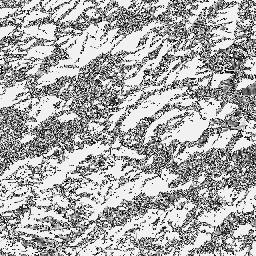

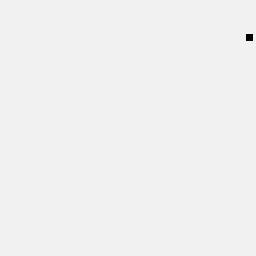

In [ ]:
vistools.display_image(im[:,:,7])
vistools.display_image(im_seg)

### Feature engineering

The last 18 features correspond to the raw bands: 3 * (Blue, Green, Red, Narrow NIR, SWIR 1, SWIR 2)

According to studies, we know that:
- Normal locusts are brown and change color to pink and yellow during the gregarious phase. Since they have a fast life cycle, we can check if we detect an increase in yellow and pink over a short period (corresponding to the three tiles). We can detect pink with: $CPI = (Red - Blue) / (Red + Blue)$  and yellow with: $CYI = (Red + Green) / Blue$. An indicator can be the sum of the two indices.
- Sand substrate with soil moisture between 5% and 25% - we can detect this with the Normalized Difference Water Index (NDWI) and the Normalized Multi-band Drought Index (NMDI)
- Sparse vegetation -> Normalized Difference Vegetation Index (NDVI) and Enhanced Vegetation Index (EVI)
- Wind presence
- Temperature

# We want to study the following variables:
- Normalized Difference Vegetation Index (NDVI): $$\text{NDVI} = \frac{\text{NIR} - \text{Red}}{\text{NIR} + \text{Red}}$$
- Enhanced Vegetation Index (EVI) $$\text{EVI} = G \times \frac{\text{NIR} - \text{Red}}{\text{NIR} + C_1 \times \text{Red} - C_2 \times \text{Blue} + L}$$
- Bare soil index:
$$\text{BSI} = \frac{(\text{SWIR} + \text{Red}) - (\text{NIR} + \text{Blue})}{(\text{SWIR} + \text{Red}) + (\text{NIR} + \text{Blue})}$$
- Normalized Difference Water Index
$$
\text{NDWI} = \frac{\text{NIR} - \text{SWIR}}{\text{NIR} + \text{SWIR}}
$$
-  Normalized Multi-band Drought Index
$$
\text{NMDI} = \frac{\text{NIR} - (\text{SWIR}_1 + \text{SWIR}_2)}{\text{NIR} + (\text{SWIR}_1 + \text{SWIR}_2)}
$$

In [ ]:
import numpy as np

def compute_remote(im):

    # Create a mask for invalid pixels (where value is -9999)
    invalid_mask = np.any(im == -9999, axis=0)

    new_im = np.zeros((256,256, 18))
    # NDVI
    blue_idx, green_idx, red_idx,nir_idx, swir1_idx, swir2_idx = [[i, i+6, i+12] for i in range(6)]
    # blue_idx = [0, 0+6, 0+12]


    ndvi_idx, evi_idx, bsi_idx, ndwi_idx, nmdi_idx, color_idx = [[i, i+6, i+12] for i in range(6)]
    NDVI = (im[:,:,nir_idx] - im[:,:,red_idx]) / (im[:,:,nir_idx] + im[:,:,red_idx] + 1e-10)
    mask_ndvi = (im[:,:,nir_idx] == -9999) | ((im[:,:,red_idx] == -9999))
    new_im[:,:,ndvi_idx] = NDVI
    new_im[:,:,ndvi_idx][mask_ndvi] = -9999

    # EVI
    EVI = 2.5 * (im[:,:,nir_idx] - im[:,:,red_idx]) / (im[:,:,nir_idx] + 6 * im[:,:,red_idx] - 7.5 * im[:,:,blue_idx] + 1+ 1e-10)
    mask_evi = (im[:,:,nir_idx] == -9999) | ((im[:,:,red_idx] == -9999))
    new_im[:,:,evi_idx] = EVI
    new_im[:,:,evi_idx][mask_evi] = -9999

    # BSI
    BSI = ((im[:,:,swir1_idx] + im[:,:,red_idx]) - (im[:,:,nir_idx] + im[:,:,blue_idx])) / ((im[:,:,swir1_idx] + im[:,:,red_idx]) + (im[:,:,nir_idx] + im[:,:,blue_idx])+ 1e-10)
    mask_bsi = (im[:,:,swir1_idx] == -9999) | ((im[:,:,red_idx] == -9999))
    new_im[:,:,bsi_idx] = BSI
    new_im[:,:,bsi_idx][mask_bsi] = -9999

    # NDWI
    NDWI = (im[:,:,nir_idx] - im[:,:,swir1_idx]) / (im[:,:,nir_idx] + im[:,:,swir1_idx]+ 1e-10)
    mask_ndwi = (im[:,:,nir_idx] == -9999) | ((im[:,:,swir1_idx] == -9999))
    new_im[:,:,ndwi_idx] = NDWI
    new_im[:,:,ndwi_idx][mask_ndwi] = -9999

    # NMDI
    NMDI = (im[:,:,nir_idx] - (im[:,:,swir1_idx] + im[:,:,swir2_idx])) / (im[:,:,nir_idx] + (im[:,:,swir1_idx] + im[:,:,swir2_idx])+ 1e-10)
    mask_nmdi = (im[:,:,nir_idx] == -9999) | ((im[:,:,swir1_idx] == -9999)) | ((im[:,:,swir2_idx] == -9999))
    new_im[:,:,nmdi_idx] = NMDI
    new_im[:,:,nmdi_idx][mask_nmdi] = -9999

    # CPY
    CPY = (im[:,:,red_idx] - im[:,:,blue_idx]) / (im[:,:,red_idx] + im[:,:,blue_idx]+ 1e-10) + (im[:,:,red_idx] + im[:,:,green_idx]) / (im[:,:,blue_idx]+ 1e-10)
    mask_cpy = (im[:,:,red_idx] == -9999) | ((im[:,:,blue_idx] == -9999)) | (im[:,:,green_idx] == -9999)
    new_im[:,:,color_idx] = CPY
    new_im[:,:,color_idx][mask_cpy] = -9999

    return new_im

print(compute_remote(im).shape)

NameError: name 'im' is not defined

In [ ]:
## modify the features of the chips
def remote_sensing_features(chips_dir, output_dir):
  chips_dir = Path(chips_dir)
  output_dir = Path(output_dir)
  output_dir.mkdir(exist_ok=True, parents=True)
  for chip_file in os.listdir(chips_dir):
    if not chip_file.endswith(".tif"):
      continue
    chip_path = chips_dir / chip_file
    output_path = output_dir / chip_file

    im = utils.readGTIFF(chip_path)
    meta = utils.readGTIFFmeta(chip_path)
    aug_array = compute_remote(im)
    aug_meta = meta
    utils.writeGTIFF(aug_array,output_path,chip_path)
  print(f"[OK] Remote indexes ajoutés dans : {output_dir}")

In [ ]:
remote_sensing_features("/content/hls_train/hls_train/chips", "/content/hls_train/hls_train/chips_aug")

/content/utils.py:109: RuntimeWarning: invalid value encountered in cast
  d.write((im.transpose([2,0,1]).astype(d.profile['dtype'])))


[OK] Remote indexes ajoutés dans : /content/hls_train/hls_train/chips_aug


In [ ]:
### move chips folder to data

import shutil

shutil.move("/content/hls_train/hls_train/chips", "/content/data")
os.rename("/content/hls_train/hls_train/chips_aug", "/content/hls_train/hls_train/chips")

In [ ]:
# Generate label mappings for the training and testing datasets
generate_label_mapping(input_dir, 'hls_train/hls_train', "train_ds.csv")
generate_label_mapping(input_dir, 'hls_test/hls_test', "test_ds.csv")

Number of rows is: 8131
CSV generated and saved to: train_ds.csv
Number of rows is: 2404
CSV generated and saved to: test_ds.csv


## Instageo Model
After creating our training and validation splits, we can move on to fine-tuning a model that includes a Prithvi backbone paired with a classification head. For regression tasks, the classification head can easily be replaced with a suitable regression head. Additionally, if a completely different model architecture is needed, it can be designed and implemented within this framework.

In [ ]:
def load_yml(filepath):
    """Load data from a YAML file.

    Args:
        filepath (str | Path): The path to the YAML file.

    Returns:
        Dict: The loaded data, or None if the file does not exist.
    """
    filepath=Path(filepath)
    with filepath.open() as f:
        return yaml.safe_load(f)

def save_yml(data,filepath):
    """Save data to a YAML file.

    Args:
        data (Dict): The data to save.
        filepath (str | Path): The file path to save the YAML to.
    """
    filepath = Path(filepath)
    with filepath.open("w") as f:
        yaml.dump(data, f)
    print(f"Data saved to {filepath}.")


## Launch training

First, compute the mean and standard deviation for the dataset using the InstaGeo command. Then update the corresponding configuration file [locust.yaml](https://github.com/instadeepai/InstaGeo-E2E-Geospatial-ML/blob/main/instageo/model/configs/locust.yaml). In this case, it has already been done for you. However, if you change the dataset split or modify the training data, you should run the command again to compute the new mean and standard deviation.

In [ ]:
!python -m instageo.model.run --config-name=locust \
    root_dir="" \
    train.batch_size=8 \
    train.num_epochs=1 \
    mode=stats \
    train_filepath="train_ds.csv" \
    dataloader.temporal_dim=3

Seed set to 1042
[2025-02-05 08:52:34,407][__main__][INFO] - Script: /content/InstaGeo-E2E-Geospatial-ML/instageo/model/run.py
[2025-02-05 08:52:34,411][__main__][INFO] - Imported hydra config:
root_dir: ''
valid_filepath: null
train_filepath: train_ds.csv
test_filepath: null
checkpoint_path: null
output_dir: null
mode: stats
train:
  learning_rate: 0.0001
  num_epochs: 1
  batch_size: 8
  class_weights:
  - 1
  - 1
  ignore_index: -1
  weight_decay: 0.1
model:
  freeze_backbone: false
  num_classes: 2
dataloader:
  bands:
  - 0
  - 1
  - 2
  - 3
  - 4
  - 5
  - 6
  - 7
  - 8
  - 9
  - 10
  - 11
  - 12
  - 13
  - 14
  - 15
  - 16
  - 17
  mean:
  - 623.2724609375
  - 1247.657958984375
  - 1772.24169921875
  - 2371.256103515625
  - 2862.867431640625
  - 2357.759765625
  std:
  - 2182.050048828125
  - 2248.420654296875
  - 2302.53515625
  - 2372.204345703125
  - 2398.52685546875
  - 2292.96435546875
  img_size: 256
  temporal_dim: 3
  replace_label:
  - -9999
  - -1
  reduce_to_zero: fal

In [ ]:
# Updat locust file
# Load the Locust model configuration file
locust_cfg_path="InstaGeo-E2E-Geospatial-ML/instageo/model/configs/locust.yaml"
# Load the YAML configuration into a dictionary
locust_cfg=load_yml(locust_cfg_path)
# Update the mean and standard deviation values in the configuration
locust_cfg["mean"]=[670.5441284179688, 1267.7974853515625, 1772.599365234375, 2415.69091796875, 2879.2431640625, 2337.822509765625]
locust_cfg["std"]=[2146.305419921875, 2203.416259765625, 2247.03515625, 2310.74755859375, 2322.708984375, 2211.968505859375]
# Save the updated configuration back to the YAML file
save_yml(locust_cfg,locust_cfg_path)

Data saved to InstaGeo-E2E-Geospatial-ML/instageo/model/configs/locust.yaml.


In [ ]:
# Train the InstaGeo model using the Locust configuration
!python -m instageo.model.run  --config-name=locust \
    hydra.run.dir="outputs/first_run" \
    root_dir="" \
    train.batch_size=8 \
    train.num_epochs=5 \
    mode=train \
    train_filepath="train_split.csv" \
    valid_filepath="validation_split.csv"

Seed set to 1042
[2025-02-05 09:49:06,502][__main__][INFO] - Script: /content/InstaGeo-E2E-Geospatial-ML/instageo/model/run.py
[2025-02-05 09:49:06,505][__main__][INFO] - Imported hydra config:
checkpoint_path: null
dataloader:
  bands:
  - 0
  - 1
  - 2
  - 3
  - 4
  - 5
  - 6
  - 7
  - 8
  - 9
  - 10
  - 11
  - 12
  - 13
  - 14
  - 15
  - 16
  - 17
  constant_multiplier: 1.0
  img_size: 256
  mean:
  - 623.2724609375
  - 1247.657958984375
  - 1772.24169921875
  - 2371.256103515625
  - 2862.867431640625
  - 2357.759765625
  no_data_value: -9999
  reduce_to_zero: false
  replace_label:
  - -9999
  - -1
  std:
  - 2182.050048828125
  - 2248.420654296875
  - 2302.53515625
  - 2372.204345703125
  - 2398.52685546875
  - 2292.96435546875
  temporal_dim: 3
mean:
- 0.0001427956303814426
- 0.01986119896173477
- 0.000194823500351049
- -0.00010462214413564652
- -0.0001869543775683269
- 3.268627643585205
mode: train
model:
  freeze_backbone: false
  num_classes: 2
output_dir: null
root_dir: ''
st

### Run Model Evaluation
 To evaluate the model, adjust the `checkpoint_path` argument to point to the desired model checkpoint. The checkpoint file is typically located in the `hydra.run.dir` directory and is named `instageo_best_checkpoint.ckpt`.
For example:
```
/kaggle/working/outputs/first_run/instageo_best_checkpoint.ckpt
```
Make sure to provide the correct path to the checkpoint file based on your training output directory.

In [ ]:
%%bash
python -m instageo.model.run --config-name=locust \
    root_dir="/kaggle/input/geo-ai-hack" \
    test_filepath="validation_split.csv" \
    train.batch_size=16 \
    checkpoint_path='/kaggle/working/outputs/first_run/instageo_best_checkpoint.ckpt' \
    mode=eval

## Make submission

In [ ]:
%%bash
python -m instageo.model.run --config-name=locust \
    root_dir="/kaggle/input/geo-ai-hack" \
    test_filepath="test_ds.csv" \
    train.batch_size=16 \
    checkpoint_path='/kaggle/working/outputs/first_run/instageo_best_checkpoint.ckpt' \
    output_dir='/kaggle/working/predictions' \
    mode=chip_inference

In [ ]:
predictions_directory = "/kaggle/working/predictions"
prediction_files = os.listdir(predictions_directory)

def get_prediction_value(row):
    matching_files = [f for f in prediction_files if (str(row['date']) in f) and (row['mgrs_tile_id'] in f)]
    if not matching_files:
        return (np.nan, np.nan)
    for file in matching_files:
        with rasterio.open(f"{predictions_directory}/{file}") as src:
            width, height = src.width, src.height
            affine_transform = rasterio.transform.AffineTransformer(src.transform)
            transformer = Transformer.from_crs(CRS.from_epsg(4326), src.crs, always_xy=True)
            x_chip, y_chip = transformer.transform(row['x'], row['y'])
            x_offset, y_offset = affine_transform.rowcol(x_chip, y_chip)

            if 0 <= x_offset < width and 0 <= y_offset < height:
                return src.read(1)[y_offset, x_offset], file
    return (np.nan, np.nan)

In [ ]:
submission_df = pd.read_csv("/kaggle/input/geo-ai-hack/test.csv")

submission_df[['prediction', 'filename']] = submission_df.apply(get_prediction_value, axis=1, result_type='expand')
submission_df[["id","prediction"]].to_csv("hls_submission.csv",index=False)